C:\Users\Admin\AppData\Local\Temp\ipykernel_26572\922193216.py:15: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


Epoch 1/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.1910 - loss: 2.9562 - val_accuracy: 0.3249 - val_loss: 2.2574
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.3123 - loss: 2.3117 - val_accuracy: 0.3571 - val_loss: 2.1021
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step - accuracy: 0.3453 - loss: 2.1735 - val_accuracy: 0.3762 - val_loss: 2.0285
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.3677 - loss: 2.0929 - val_accuracy: 0.4028 - val_loss: 1.9512
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.3883 - loss: 2.0115 - val_accuracy: 0.4138 - val_loss: 1.9003
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - accuracy: 0.3996 - loss: 1.9722 - val_accuracy: 0.4286 - val_loss: 1.8644
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.4065 - loss: 1.9243 - val_accuracy: 0.4426 - val_loss: 1.8346
Epoch 8/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step - accuracy: 0.4167 - loss: 1.8931 - 

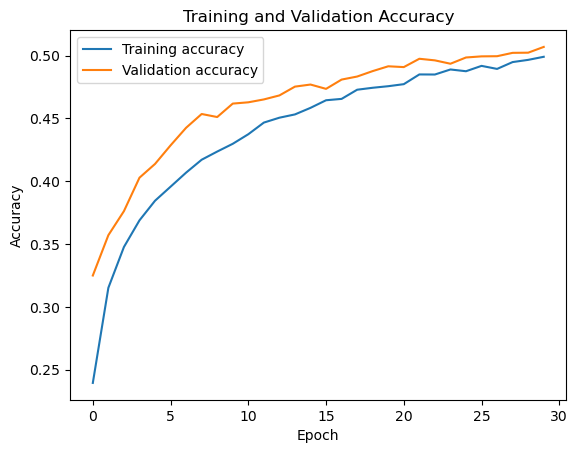

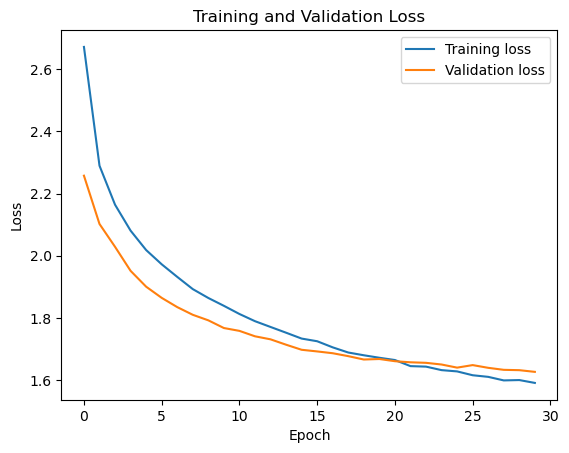

246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.5080 - loss: 1.6076


Test Loss: 1.626295804977417
Test Accuracy: 0.5070134997367859


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.applications import MobileNetV2
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load MobileNetV2 pre-trained model without the top (classification) layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Adding custom classification layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load and preprocess the data
data = []
labels = []
classes = 43
cur_path = os.getcwd()

for i in range(classes):
    path = os.path.join(cur_path, 'train', str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            image = image.resize((32, 32))  # Resize to 32x32 pixels
            image = np.array(image)
            data.append(image)
            labels.append(i)
        except Exception as e:
            print(f"Error loading image {a}: {e}")

data = np.array(data)
labels = np.array(labels)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Preprocess the data (normalize and one-hot encode labels)
X_train = X_train / 255.0
X_test = X_test / 255.0
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_test, y_test))

# Plotting graphs for accuracy and loss
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the model
model.save("traffic_classifier_mobilenet.h5")
